<a href="https://colab.research.google.com/github/majid9418/Breast-Tumor-Classification-Histopathological/blob/main/New_binary_classification_BreakHis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import glob
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

# Define base directory
base_dir = '/content/drive/MyDrive/breakhis/BreaKHis_v1/histology_slides/breast'

# Define subdirectories for benign and malignant
benign_dir = os.path.join(base_dir, 'benign')
malignant_dir = os.path.join(base_dir, 'malignant')

# Create directories for training and validation data
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for benign and malignant in train and validation folders
for category in ['benign', 'malignant']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Function to split data and copy to respective directories
def split_and_copy_images(source_dir, train_dest_dir, val_dest_dir, split_ratio=0.2):
    image_files = glob.glob(os.path.join(source_dir, '**', '*.png'), recursive=True)
    train_files, val_files = train_test_split(image_files, test_size=split_ratio, random_state=42)

    for file in train_files:
        shutil.copy(file, train_dest_dir)

    for file in val_files:
        shutil.copy(file, val_dest_dir)

# Split and copy images for benign and malignant
split_and_copy_images(benign_dir, os.path.join(train_dir, 'benign'), os.path.join(val_dir, 'benign'))
split_and_copy_images(malignant_dir, os.path.join(train_dir, 'malignant'), os.path.join(val_dir, 'malignant'))

# General data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.9, 1.1],
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create general data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Calculate the number of images in each class
class_counts = {category: len(glob.glob(os.path.join(train_dir, category, '*.png'))) for category in ['benign', 'malignant']}
print(class_counts)

# Determine underrepresented class
mean_count = np.mean(list(class_counts.values()))
underrepresented_class = [category for category, count in class_counts.items() if count < mean_count]
print(f"Underrepresented class: {underrepresented_class}")

# Custom augmentation pipeline for underrepresented class
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.2),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.01*255, 0.05*255))
])

# Augment and add images for underrepresented class
for category in underrepresented_class:
    category_dir = os.path.join(train_dir, category)
    images = glob.glob(os.path.join(category_dir, '*.png'))

    for img_path in images:
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        for _ in range(int(mean_count / len(images))):
            aug_images = aug_pipeline(images=img_array.astype(np.uint8))
            for aug_img in aug_images:
                aug_img_path = os.path.join(category_dir, f"aug_{os.path.basename(img_path)}")
                aug_img = tf.keras.preprocessing.image.array_to_img(aug_img)
                aug_img.save(aug_img_path)

# Re-create generators after augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Mounted at /content/drive
Found 6327 images belonging to 2 classes.
Found 1582 images belonging to 2 classes.
{'benign': 1984, 'malignant': 4343}
Underrepresented class: ['benign']
Found 8311 images belonging to 2 classes.
Found 1582 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

# Define base directory
base_dir = '/content/drive/MyDrive/breakhis/BreaKHis_v1/histology_slides/breast'

# Define training and validation directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# General data augmentation for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.9, 1.1],
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Define the model for binary classification
model = Sequential([
    EfficientNetB5(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    GlobalAveragePooling2D(),
    Dropout(0.8),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_filepath = '/content/drive/MyDrive/efficientnet_checkpoints/best_model.keras'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(scheduler)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=37,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_callback]
)

# Load the best model
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Evaluate the best model
loss, accuracy = best_model.evaluate(validation_generator, verbose=0)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

# Generate predictions and compute confusion matrix
validation_steps = validation_generator.samples // validation_generator.batch_size
y_pred = best_model.predict(validation_generator, steps=validation_steps, verbose=1)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = validation_generator.classes[:len(y_pred_labels)]

conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['benign', 'malignant']

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

# Define base directory
base_dir = '/content/drive/MyDrive/breakhis/BreaKHis_v1/histology_slides/breast'

# Define training and validation directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# General data augmentation for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.9, 1.1],
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use 50% of the validation set for actual validation during training
)

test_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # Use the remaining 50% as a test set
    shuffle=False  # Important: do not shuffle to keep labels aligned for evaluation
)
# Define the model for binary classification
model = Sequential([
    EfficientNetB5(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    GlobalAveragePooling2D(),
    Dropout(0.8),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_filepath = '/content/drive/MyDrive/efficientnet_checkpoints/best_weights.weights.h5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=28,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_callback]
)

# Load the best model
#best_model = tf.keras.models.load_model(checkpoint_filepath)
model.load_weights(checkpoint_filepath)

model.save('/content/drive/MyDrive/efficientnet_checkpoints/best_model.h5')
# Evaluate the best model
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print(f'Validation loss: {loss}, Validation accuracy: {accuracy * 100:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


# Evaluate the best model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy * 100:.2f}%')

# Generate predictions on the test set
test_steps = test_generator.samples // test_generator.batch_size
y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred_labels)]

# Compute the confusion matrix for the test set
conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['benign', 'malignant']

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for the test set
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)


Found 8311 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Epoch 1/28


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7646 - loss: 0.4942 
Epoch 1: val_loss improved from inf to 0.67259, saving model to /content/drive/MyDrive/efficientnet_checkpoints/best_weights.weights.h5
260/260 ━━━━━━━━━━━━━━━━━━━━ 5274s 19s/step - accuracy: 0.7649 - loss: 0.4937 - val_accuracy: 0.6865 - val_loss: 0.6726 - learning_rate: 1.0000e-04
Epoch 2/28
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9256 - loss: 0.2002
Epoch 2: val_loss improved from 0.67259 to 0.64321, saving model to /content/drive/MyDrive/efficientnet_checkpoints/best_weights.weights.h5
260/260 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.9257 - loss: 0.2001 - val_accuracy: 0.6877 - val_loss: 0.6432 - learning_rate: 1.0000e-04
Epoch 3/28
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9489 - loss: 0.1468
Epoch 3: val_loss did not improve from 0.64321
260/260 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9489 - loss: 0.1468 - val_accuracy: 0.7155 - val_loss: 0.7236 - learning_rate: 1.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define base directory
base_dir = '/content/drive/MyDrive/breakhis/BreaKHis_v1/histology_slides/breast'

# Define training and validation directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# General data augmentation for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.9, 1.1],
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use 50% of the validation set for actual validation during training
)

test_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # Use the remaining 50% as a test set
    shuffle=False  # Important: do not shuffle to keep labels aligned for evaluation
)

# Recreate the model architecture
model = Sequential([
    EfficientNetB5(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    GlobalAveragePooling2D(),
    Dropout(0.8),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

# Build the model by passing in a dummy input shape
model.build((None, 224, 224, 3))
# Load the weights from the saved model
model.load_weights('/content/drive/MyDrive/efficientnet_checkpoints/best_model.keras')

# Re-compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint_filepath = '/content/drive/MyDrive/efficientnet_checkpoints/best_model.keras'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

lr_callback = LearningRateScheduler(scheduler)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Continue training the model
remaining_epochs = 27  # Adjust based on how many epochs you want to continue
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=remaining_epochs,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_callback]
)

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(validation_generator, verbose=0)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy * 100:.2f}%')

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy * 100:.2f}%')

# Generate predictions on the test set
test_steps = test_generator.samples // test_generator.batch_size
y_pred = best_model.predict(test_generator, steps=test_steps, verbose=1)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred_labels)]

# Compute the confusion matrix for the test set
conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['benign', 'malignant']

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Print classification report for the test set
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


Found 8311 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/27


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.9800 - loss: 0.0727 
Epoch 1: val_loss improved from inf to 7.17775, saving model to /content/drive/MyDrive/efficientnet_checkpoints/best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 4468s 16s/step - accuracy: 0.9800 - loss: 0.0727 - val_accuracy: 0.3300 - val_loss: 7.1777 - learning_rate: 1.0000e-04
Epoch 2/27
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9874 - loss: 0.0490
Epoch 2: val_loss improved from 7.17775 to 1.95112, saving model to /content/drive/MyDrive/efficientnet_checkpoints/best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9874 - loss: 0.0490 - val_accuracy: 0.3515 - val_loss: 1.9511 - learning_rate: 1.0000e-04
Epoch 3/27
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9895 - loss: 0.0417
Epoch 3: val_loss improved from 1.95112 to 0.49520, saving model to /content/drive/MyDrive/efficientnet_checkpoints/best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9895 - lo

Found 791 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test loss: 0.06346616894006729, Test accuracy: 98.23%
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 999ms/step


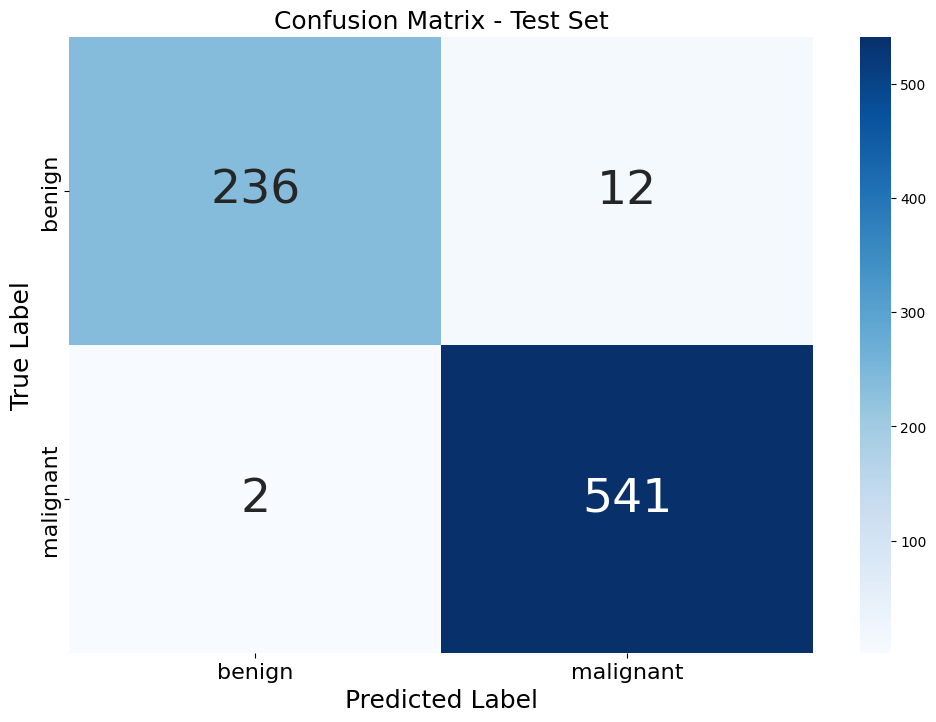

              precision    recall  f1-score   support

      benign       0.99      0.95      0.97       248
   malignant       0.98      1.00      0.99       543

    accuracy                           0.98       791
   macro avg       0.98      0.97      0.98       791
weighted avg       0.98      0.98      0.98       791



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define base directory for test data
base_dir = '/content/drive/MyDrive/breakhis/BreaKHis_v1/histology_slides/breast'
val_dir = os.path.join(base_dir, 'validation')

# Test data augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Load the test set
test_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # Use the remaining 50% as the test set
    shuffle=False  # Important: do not shuffle to keep labels aligned for evaluation
)
# Recreate the model architecture
model = Sequential([
    EfficientNetB5(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    GlobalAveragePooling2D(),
    Dropout(0.8),
    Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

# Build the model
model.build((None, 224, 224, 3))

# Load the saved weights instead of the full model
model.load_weights('/content/drive/MyDrive/efficientnet_checkpoints/best_model.keras')

# Compile the model again
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


# Evaluate the best model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy * 100:.2f}%')


# Generate predictions on the test set
#test_steps = test_generator.samples // test_generator.batch_size
#y_pred = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred > 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred_labels)]

# Compute the confusion matrix for the test set
conf_matrix = confusion_matrix(y_true, y_pred_labels)
class_names = ['benign', 'malignant']

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 34})
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.title('Confusion Matrix - Test Set',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Print classification report for the test set
report = classification_report(y_true, y_pred_labels, target_names=class_names)
print(report)
